<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 5: deep learning для обработки звука</center></h2>

# Введение

В этом задании Вы поработаете и разберетесь в деталях с форматами представления аудиоданных в задачах глубинного обучения, а так же напишете несколько моделей для классификации аудиозаписей.

В процессе выполнения Вы познакомитесь:
* С алгоритмом построения Мел-спектрограммы
* Рекуррентными и сверточными классификаторами аудиоданных
* Алгоритмом аугментации аудиоданных SpecAugment

In [1]:
import os
from posixpath import join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torchaudio
from IPython import display
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset

%matplotlib inline

# assert torch.__version__.startswith("1.8.0")
# assert torchaudio.__version__ == "0.8.0"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
device

'cuda'

# Классификация аудиозаписей.

В этом домашнем задании Вам предстоит классифицировать аудиозаписи из датасета [UrbanSound8K](https://urbansounddataset.weebly.com/urbansound8k.html).

Данный датасет состоит из 8732 записей, разбитых на train/val/test датасеты. 

![image](https://paperswithcode.com/media/datasets/UrbanSound8K-0000003722-02faef06.jpg)

Каждая аудиозапись содержит запись шума города и принадлежит одному из 10 классов: 

`[air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music]`


## Задание 1 (1 балл). Знакомство с данными.

1. Скачайте датасет из [Google Drive](https://drive.google.com/drive/folders/1Q1mgopM_aQToKdSRlTI9zFW83sOqvrCS?usp=sharing) c и распакуйте в папку `./data`.

2. Напишите `AudioDataset` класс, который будет принимать путь к файлам `train_part.csv` и `val_part.csv` и возращать тройки объектов `(x, y, len)`, где `x` - аудиозапись, `y` - класс аудиозаписи, `len` - длина аудиозаписи. Аудиозаписи **не должны постоянно храниться в RAM**, подгрузку _wav_ файлов надо сделать при запросе через `__getitem__` метод. Кроме того, надо сделать паддинг аудиозаписи - если она короче чем `pad_size` параметр, надо дополнять ее нулями.

3. С помощью функции `display.Audio` проиграйте в ноутбуке пару аудиозаписей.


In [3]:
# скачаем и распакуем данные
!rm -r ./data
!mkdir ./data/
!pip install gdown
!cd ./data && gdown --id '1057RRnXefWOCvpzjSnRA-Xl-O3NnX8Vq' && unzip HW2_dataset

"rm" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
ЋиЁЎЄ  ў бЁ­в ЄбЁбҐ Є®¬ ­¤л.


Access denied with the following error:


C:\Users\playi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gdown\cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id='1057RRnXefWOCvpzjSnRA-Xl-O3NnX8Vq' 



In [4]:
# классы данных
classes = [
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music",
]

In [5]:
class AudioDataset(Dataset):
    def __init__(
        self,
        path_to_csv: str,
        path_to_folder: str,
        pad_size: int = 384000,
        sr: int = 44100,
    ):
        self.csv: pd.DataFrame = pd.read_csv(path_to_csv)[["ID", "Class"]]
        self.path_to_folder = path_to_folder
        self.pad_size = pad_size

        self.sr = sr

        self.class_to_idx = {classes[i]: i for i in range(10)}

    def __getitem__(self, index: int):
        ret = {}
        path,cl = self.csv.iloc[index]
#         print(cl)
        ret['y'] = self.class_to_idx[cl]
        path = join(self.path_to_folder, str(path)+".wav")
#         print(path)
        wav, sr = torchaudio.load(path)
        wav = wav.view(-1)
        ret['len']  = wav.size()[0]
        if ret['len']<384000:
            wav = torch.nn.functional.pad(wav,(0,self.pad_size-ret['len']),value=0)
        ret['x'] = wav
#         ret['len'] = sr
        return ret
    def __len__(self):
        return self.csv.shape[0]

In [6]:
# создадим датасеты
train_dataset = AudioDataset(
    "./data/urbansound8k/train_part.csv", "./data/urbansound8k/data"
)
val_dataset = AudioDataset(
    "./data/urbansound8k/val_part.csv", "./data/urbansound8k/data"
)

In [7]:
# проверим размеры датасетов
assert len(train_dataset) == 4500
assert len(val_dataset) == 935

In [8]:
train_dataset.csv[train_dataset.csv['ID']==0].values[0]

array([0, 'siren'], dtype=object)

In [9]:
train_dataset.csv.iloc[0]

ID                  7131
Class    air_conditioner
Name: 0, dtype: object

In [10]:
print(train_dataset.__getitem__(0))

{'y': 0, 'len': 176400, 'x': tensor([0.0428, 0.0388, 0.0291,  ..., 0.0000, 0.0000, 0.0000])}


In [11]:
# проверим возращаемые значения __getitem__
item = train_dataset.__getitem__(0)
print(item["x"].shape)
assert item["x"].shape == (384000,)
assert item["y"] == 0
assert item["len"] == 176400

torch.Size([384000])


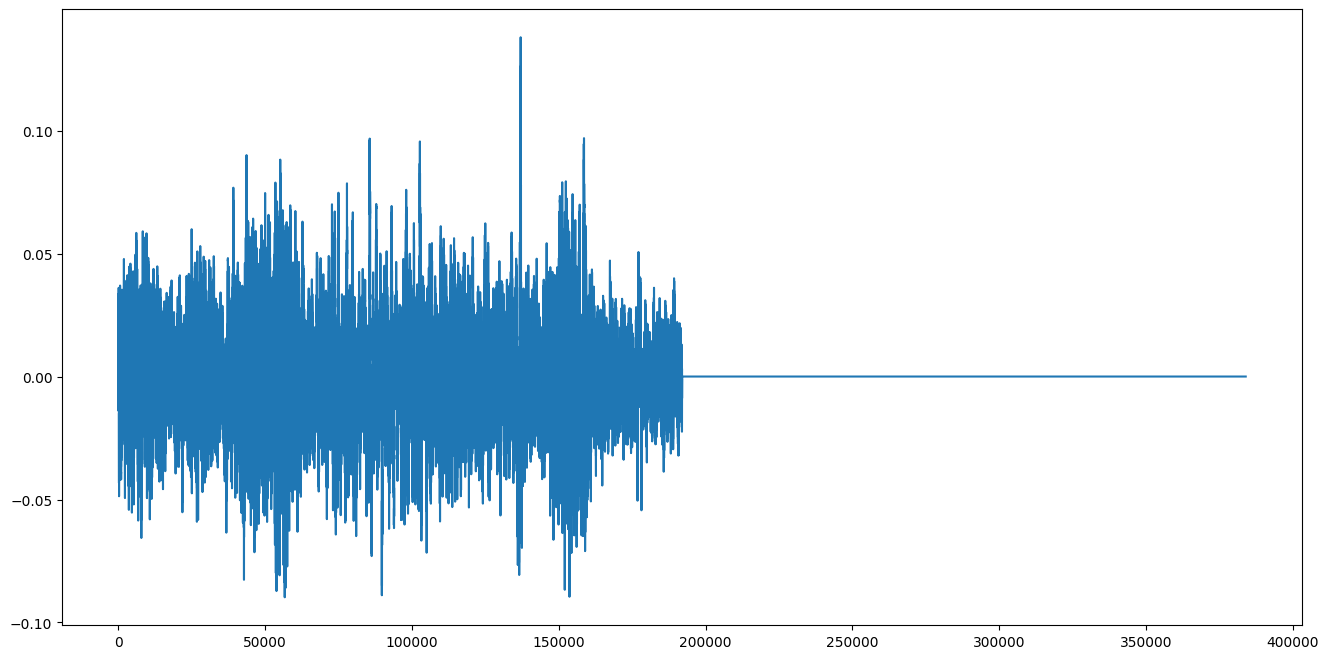

In [12]:
# нарисуем и проиграем аудиозаписить
item = train_dataset.__getitem__(1)
plt.figure(figsize=(16, 8))
plt.plot(item["x"])

display.Audio(item["x"], rate=train_dataset.sr)

In [13]:
# создадим даталоадеры
train_dataloader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, pin_memory=True, drop_last=True
)
val_dataloader = DataLoader(val_dataset, batch_size=32, pin_memory=True)

## Задание 2. Рекуррентная сеть для классификации аудиозаписей по сырому сигналу (2 балла)

По своей сути аудиозапись является ни чем иным, как временным рядом - замеры микрофона делаются через равные промежутки времени и хранятся в виде последовательности. 

Как известно, рекуррентные сети отлично подходят для работы с различными последовательностями, в том числе и с временными рядами.

Обучим простую реккурентную сеть для классификации аудиозаписей.

1. Разбейте аудизаписить на окошки размером `1024` с шагом `256`. Для этих целей отлично подойдет метод `torch.Tensor.unfold`.
1. Применим к каждому получившемуся окну аудиосигнала полносвязную сеть с активациями `ReLU` и  внутренними размерностям `(1024 -> 256 -> 64 -> 16)`.
2. По получившимся последовательностям пройдемся двунаправленой (`bidirectional=True`) LSTM с двумя слоями (`layers=2`).
3. Склеим c помощью `torch.cat` последние `hidden_state` для каждого слоя и применим к ним полносвязную сеть `(2 * hidden_size * num_layers -> 256 -> 10)` с активацией `ReLU`.

![title](./rnn_raw.png)

*Совет*: для убыстрения обучения имеет смысл в полносвязные сети добавить `BatchNorm`.

In [14]:
class RecurrentRawAudioClassifier(nn.Module):
    def __init__(
        self,
        num_classes=10,
        window_length=1024,
        hop_length=256,
        hidden=256,
        num_layers=2,
    ) -> None:
        super().__init__()

        self.window_length = window_length
        self.hop_length = hop_length
        self.hidden = hidden
        self.num_layers = num_layers
        ### YOUR CODE IS HERE ######
        self.first_mlp = nn.Sequential(nn.Linear(self.window_length,256), 
                                       nn.BatchNorm1d(1497),
                                       nn.ReLU(),
                                      nn.Linear(256,64), 
                                       nn.BatchNorm1d(1497),
                                       nn.ReLU(),
                                      nn.Linear(64,16), 
                                       nn.BatchNorm1d(1497),
                                       nn.ReLU())

        self.rnn = torch.nn.LSTM(input_size=16,hidden_size=hidden,num_layers=self.num_layers,bidirectional=True,batch_first =True)

        self.final_mlp = nn.Sequential(nn.Linear(2*hidden*num_layers,256), nn.BatchNorm1d(256),nn.ReLU(),
                                      nn.Linear(256,10), nn.BatchNorm1d(10),nn.ReLU())
        ### THE END OF YOUR CODE ###

    def forward(self, x, lens) -> torch.Tensor:
        # разбейте сигнал на окна
        # batch_windows.shape == (B, NUM WINDOWS, 1024)
        x = x.unfold(1,1024,256)

        # примените к каждому окну полносвязную сеть
        # batch_windows_feautures.shape == (B, NUM WINDOWS, 16)
        x = self.first_mlp(x)

        # примените к получившемся последовательностям LSTM и возьмите hidden state
        _, (x, _) = self.rnn(x)
        # склейте hidden_state по слоям
        # hidden_flattened.shape = (B, 2 * hidden_size * num_layers)
        x = torch.transpose(x,0,1)
        x = x.reshape(-1,2*self.num_layers*self.hidden)

        # примените полносвязную сеть и получим логиты классов
        return self.final_mlp(x)  # your code here

Обучим получившуюся модель.

In [152]:
def train_audio_clfr(
    model,
    optimizer,
    train_dataloader,
    sr,
    criterion=torch.nn.CrossEntropyLoss(),
    data_transform=None,
    augmentation=None,
    num_epochs=10,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    verbose_num_iters=10,
    n_mels = 64
):
    model.train()
    iter_i = 0

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        for batch in train_dataloader:
            x = batch["x"].to(device)
            y = batch["y"].to(device)
            lens = batch["len"].to(device)

            # применяем преобразование входных данных
            if data_transform:
                x, lens = data_transform(x, lens, device=device, sr=sr,n_mels = n_mels)

            # примеменяем к логмелспектрограмме аугментацию
            if augmentation:
                x, lens = augmentation(x, lens)
            probs = model(x, lens)
            optimizer.zero_grad()
            loss = criterion(probs, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

            # считаем точность предсказания
            pred_cls = probs.argmax(dim=-1)
            train_accuracies.append((pred_cls == y).float().mean().item())

            iter_i += 1

            # раз в verbose_num_iters визуализируем наши лоссы и семплы
            if iter_i % verbose_num_iters == 0:
                clear_output(wait=True)

                print(f"Epoch {epoch}")

                plt.figure(figsize=(10, 5))

                plt.subplot(1, 2, 1)
                plt.xlabel("Iteration")
                plt.ylabel("Train loss")
                plt.plot(np.arange(iter_i), train_losses)

                plt.subplot(1, 2, 2)
                plt.xlabel("Iteration")
                plt.ylabel("Train acc")
                plt.plot(np.arange(iter_i), train_accuracies)

                plt.show()

    model.eval()

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [17]:
# создадим объекты модели и оптимизатор
rnn_raw = RecurrentRawAudioClassifier()
rnn_raw.to(device)
optim = torch.optim.Adam(rnn_raw.parameters(), lr=3e-4)

Epoch 9


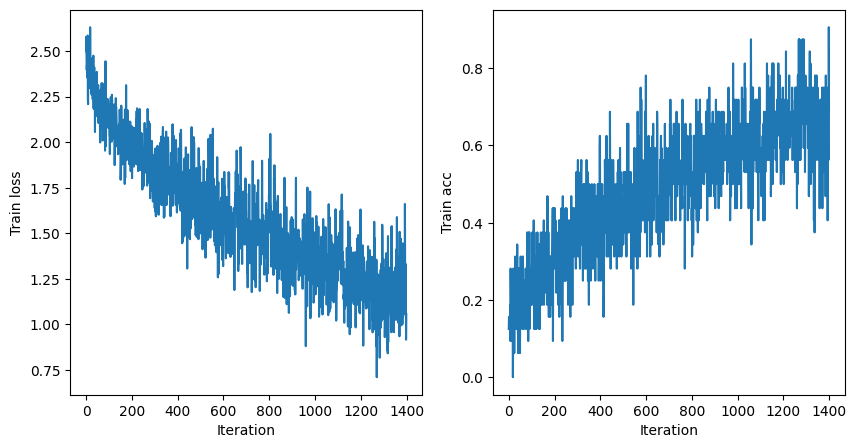

In [18]:
# обучим модель
train_audio_clfr(rnn_raw, optim, train_dataloader, train_dataset.sr)

Посчитаем метрики на валидационном датасете.

In [91]:
def plot_confusion_matrix(model, val_dataloader, sr, device, data_transform=None,n_mels = 64):
    pred_true_pairs = []
    for batch in val_dataloader:
        x = batch["x"].to(device)
        y = batch["y"].to(device)
        lens = batch["len"].to(device)

        with torch.no_grad():
            if data_transform:
                x, lens = data_transform(x, lens, sr=sr, device=device,n_mels = n_mels)

            probs = model(x, lens)

            pred_cls = probs.argmax(dim=-1)

        for pred, true in zip(pred_cls.cpu().detach().numpy(), y.cpu().numpy()):
            pred_true_pairs.append((pred, true))

    print(f"Val accuracy: {np.mean([p[0] == p[1] for p in pred_true_pairs])}")

    cm_df = pd.DataFrame(
        confusion_matrix(
            [p[1] for p in pred_true_pairs],
            [p[0] for p in pred_true_pairs],
            normalize="true",
        ),
        columns=classes,
        index=classes,
    )
    sn.heatmap(cm_df, annot=True)

Val accuracy: 0.29732620320855613


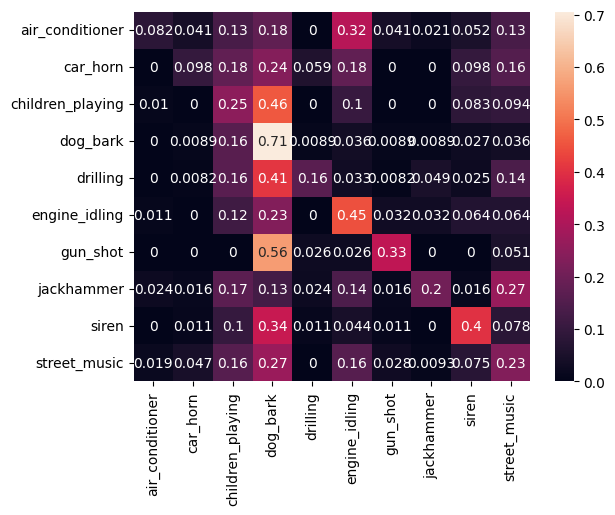

In [20]:
plot_confusion_matrix(rnn_raw, val_dataloader, train_dataset.sr, device)

*Вопрос* : Сильно ли отличается качество модели на тренировочной и валидационной выборке? Если да, то как думаете, в чем причина?

Эта модель скорее учится угадывать профиль волны для каждого класса, что вообще само по себе не эффективно, потому как они могут достаточно сильно различаться внутри даже одного класса из-за разных громкостех звука, тона, от того двигается объект с которого это записывали или нет и т.д. Поэтому модель скорее переобучается искать просто такой же профиль и не угадывает если изменена например близость объект, а соответсвенно громкость например.

## Задание 3. Построение Мел-cпектрограмм. (2 балла)

Сырой сигнал очень чувствителен ко многим факторам - увеличение/уменьшение громкости, внешние шумы, сменение тембра говорящего очень резко меняют сырой сигнал. Это влияет и на качество глубоких сетей, обученных на сыром аудиосигнале.

Для построения надежных и устойчивых к переобучению моделей используют другое представление аудиоданных - спектрограммы, в том числе Мел-спектрограмму.

Идея её построения заключается в следующем:
1. Сигнал разбивается на временные интервалы (с пересечениями)
2. К каждому временному интервалу применяется фильтр (как правило косинусоидальный)
3. К профильтрованному сигналу применяется дискретное преобразование Фурье и вычисляются спектральные признаки сигнала.
4. Спектральные признаки с помощью логарифмического преобразования приводятся в Мел-шкалу.

![image](https://antkillerfarm.github.io/images/img2/Spectrogram_5.png)

В этом задании мы сами шаг за шагом напишем алгоритм построения мелспектрограммы и сравнимся с референсной функцией из `torchaudio`.

In [18]:
from torchaudio.transforms import MelSpectrogram


# референсная функця
def compute_log_melspectrogram_reference(wav_batch, lens, sr, device="cpu"):
    featurizer = MelSpectrogram(
        sample_rate=sr,
        n_fft=1024,
        win_length=1024,
        hop_length=256,
        n_mels=64,
        center=False,
    ).to(device)

    return torch.log(featurizer(wav_batch).clamp(1e-5)), lens // 256

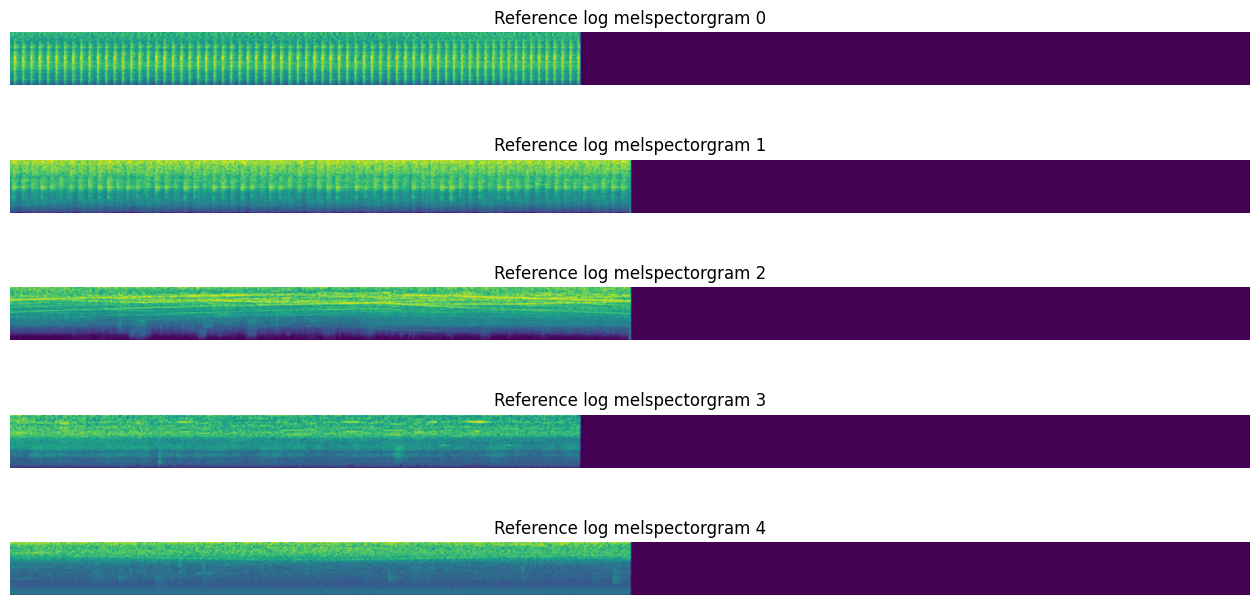

In [19]:
# возьмем случайный батч
for batch in train_dataloader:
    break

wav_batch = batch["x"]
lens = batch["len"]

# посчитаем лог мелспектрограммы
log_melspect, lens = compute_log_melspectrogram_reference(
    wav_batch, lens, train_dataset.sr
)

# нарисуем получившиеся референсные значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
    axes[i].axis("off")
    axes[i].set_title(f"Reference log melspectorgram {i}")
    axes[i].imshow(log_melspect[i].numpy())

Теперь сделаем то же самое сами. 

In [20]:
sr = train_dataset.sr
n_fft = 1024
win_length = 1024
hop_length = 256
n_mels = 64

In [21]:
wav_batch.shape

torch.Size([32, 384000])


Для начала с помощью метода `unfold` разделим аудиосигнал на окна размера `win_lenght` через промежутки `hop_lenght`.

In [22]:
windows = wav_batch.unfold(1,win_length,hop_length)
assert windows.shape == (32, 1497, 1024)

Нарисуем и проиграем сигнал из одного окна.

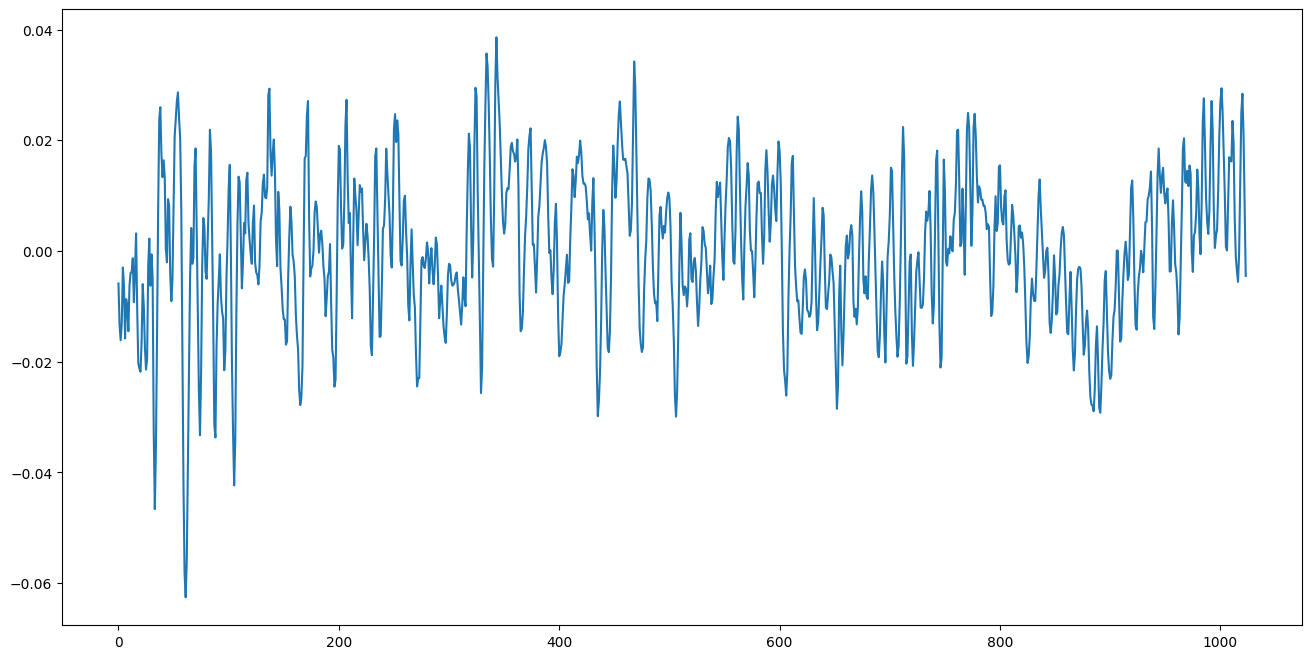

In [23]:
plt.figure(figsize=(16, 8))
plt.plot(windows[0, 0])

display.Audio(windows[0, 0], rate=train_dataset.sr)

Теперь нам надо применить косинуисальный фильтр к сигналу из окна. Для этого с помощью `torch.hann_window` создадим косинусоидальный фильтр и умножим его поэлементно на все окна.

In [24]:
filter_ =torch.hann_window(win_length)
windows_with_applied_filter = windows * filter_[None, None, :]

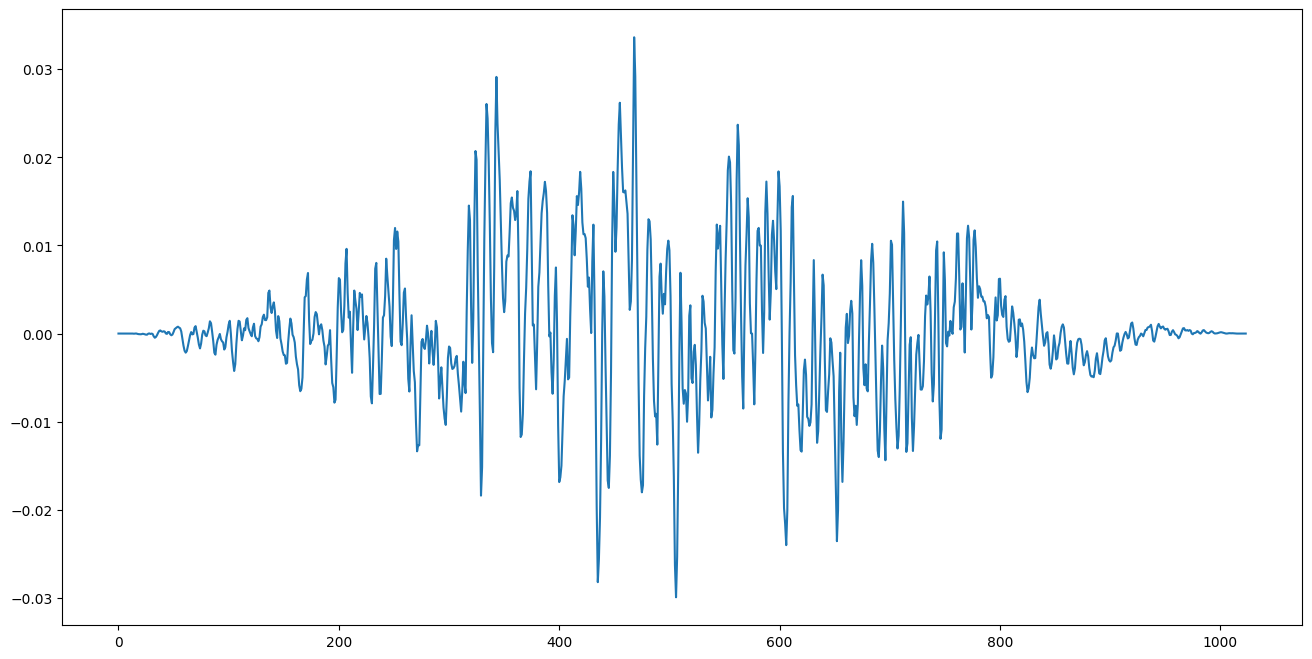

In [25]:
plt.figure(figsize=(16, 8))
plt.plot(windows_with_applied_filter[0, 0])

display.Audio(windows_with_applied_filter[0, 0], rate=train_dataset.sr)

С помощью `torch.fft.fft` примените дискретное преобразование фурье к каждому окну и возьмите первые `n_fft // 2 + 1` компоненты.

Дальше с помощью возведения элементов тензора в квадрат и `torch.abs()` получите магнитуды.

In [26]:
fft_features = torch.fft.fft(windows_with_applied_filter,dim=2)[...,:n_fft//2+1]
print(fft_features.shape)
fft_magnitudes = torch.abs(fft_features**2)
assert fft_magnitudes.shape == (32, 1497, 513)

torch.Size([32, 1497, 513])


Через `torchaudio.transforms.MelScale` создайте класс для перевода магнитуд в Мел-шкалу.

In [27]:
melscale = torchaudio.transforms.MelScale(n_mels,sr,n_stft =n_fft//2+1)

Нелинейное преобразование для перевода в Мел-шкалу выглядит следующим образом.

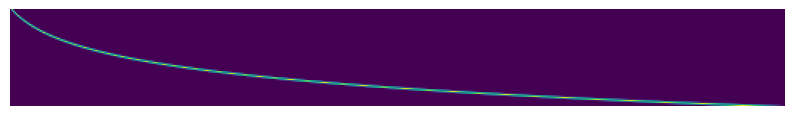

In [28]:
plt.figure(figsize=(10, 5))
plt.axis("off")
plt.imshow(melscale.fb.numpy().transpose())

Примените Мел-шкалу к магнитудам.

In [29]:
print(fft_magnitudes.shape)
mel_spectrogram = melscale(fft_magnitudes.transpose(1,2))
assert mel_spectrogram.shape == (32, 64, 1497)

torch.Size([32, 1497, 513])


Сделайте обрезку значений по `1e-5` и примените `torch.log` для получения логарифмированной Мел-спектрограммы.

In [30]:
logmel_spectrogram = torch.log(torch.where(mel_spectrogram>1e-5,mel_spectrogram,1e-5))
assert logmel_spectrogram.shape == (32, 64, 1497)

Полученные логарифмированные Мел-Спектрограммы должны совпадать с референсными.

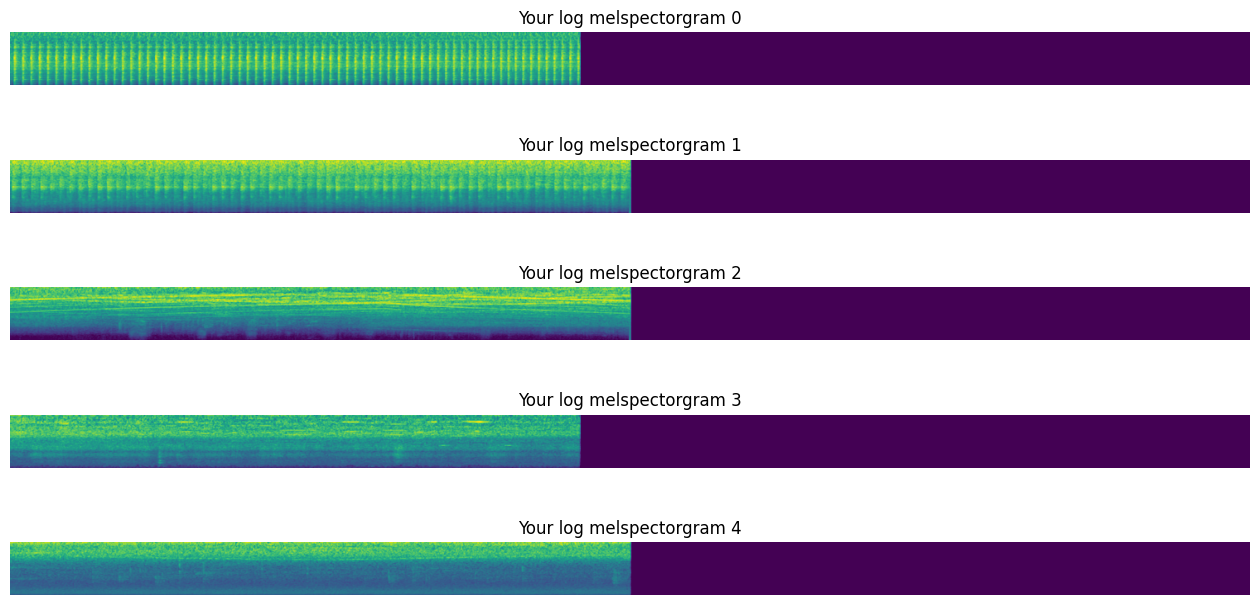

In [31]:
# нарисуем получившиеся значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
    axes[i].axis("off")
    axes[i].set_title(f"Your log melspectorgram {i}")
    axes[i].imshow(logmel_spectrogram[i].numpy())

Теперь оформим эту логику в функцию.

In [167]:
# ваша реализация
def compute_log_melspectrogram(batch, lens, sr, device="cpu",n_fft = 1024,win_length = 1024,hop_length = 256,n_mels = 64):
    batch = batch.unfold(1,win_length,hop_length).to(device)
    filter_ =torch.hann_window(win_length).to(device)
    batch = batch * filter_[None, None, :]
    batch = torch.fft.fft(batch,dim=2)[...,:n_fft//2+1]
    batch = torch.abs(batch**2)
    melscale = torchaudio.transforms.MelScale(n_mels=n_mels,sample_rate=sr,n_stft =n_fft//2+1).to(device)
    batch = melscale(batch.transpose(1,2))
    batch = torch.log(torch.where(batch>1e-5,batch,1e-5))
    return batch,lens

Финальная проверка.

In [168]:
assert torch.allclose(
    compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sr)[0],
    compute_log_melspectrogram(wav_batch, lens, train_dataset.sr)[0],
    atol=1e-5,
)

## Задание 4. Рекуррентная сеть для классификации аудиозаписей по логарифмированным Мел-спектрограммам (1 балл)

Измените реализацию рекуррентной сети из задания 2, таким образом, чтобы она вместо сырого сигнала смогла принимать логарифмированные Мел-спетрограммы:
1. Уберите шаги 1-2
2. Сделайте вход LSTM равным 64

![arch_mel](./rnn_mel.png)

**За реализацию архитектуры дается 0.5 балла.**

In [169]:
class RecurrentMelSpectClassifier(nn.Module):
    def __init__(
        self,
        num_classes=10,
        window_length=1024,
        hop_length=256,
        hidden=256,
        num_layers=2,
    ) -> None:
        super().__init__()

        self.window_length = window_length
        self.hop_length = hop_length
        self.hidden = hidden
        self.num_layers = num_layers

        ### YOUR CODE IS HERE ######

        self.rnn = torch.nn.LSTM(input_size=64,hidden_size=hidden,num_layers=self.num_layers,bidirectional=True,batch_first =True)

        self.final_mlp = nn.Sequential(nn.Linear(2*hidden*num_layers,2048), nn.BatchNorm1d(2048),nn.ReLU(),
                                      nn.Linear(2048,256), nn.BatchNorm1d(256),nn.ReLU(),
                                       nn.Linear(256,10))
        ### THE END OF YOUR CODE ###

    def forward(self, x, lens): 
        x = torch.transpose(x,1,2)
        _, (x, _) = self.rnn(x)
        x = torch.transpose(x,0,1)
        x = x.reshape(-1,2*self.num_layers*self.hidden)
        return self.final_mlp(x)

In [174]:
# создадим даталоадеры
train_dataloader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, pin_memory=True, drop_last=True
)
val_dataloader = DataLoader(val_dataset, batch_size=32, pin_memory=True)

In [175]:
rnn_mel = RecurrentMelSpectClassifier(hidden=256,
        num_layers=2)
rnn_mel.to(device)

optim = torch.optim.Adam(rnn_mel.parameters(), lr=1e-4)

Epoch 9


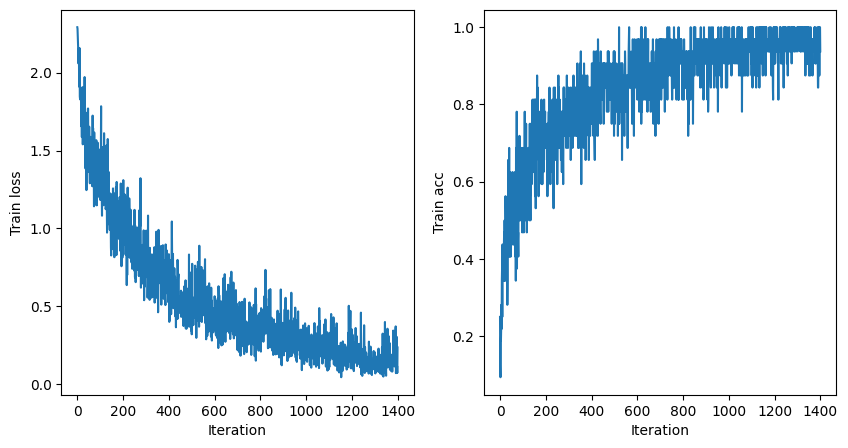

In [176]:
train_audio_clfr(
    rnn_mel,
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram,
    num_epochs=10,n_mels = 64
)

Epoch 2


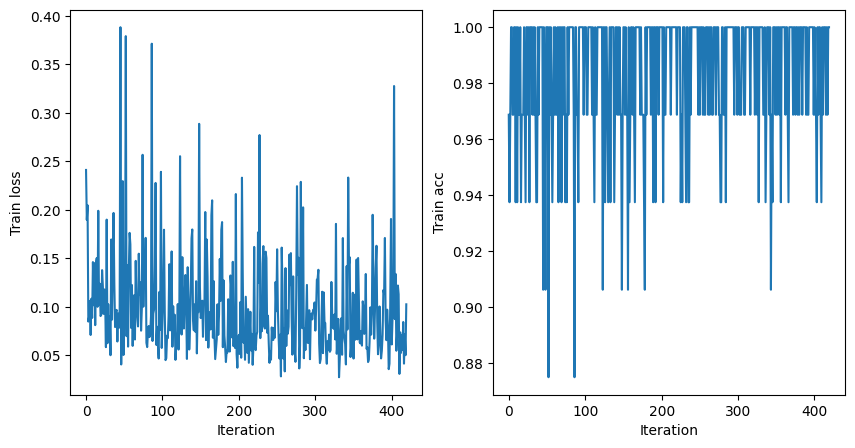

In [178]:
optim = torch.optim.Adam(rnn_mel.parameters(), lr=1e-6)
train_audio_clfr(
    rnn_mel,
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram,
    num_epochs=3,n_mels = 64
)

Посчитаем метрики на валидационном датасете.

**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.8 на валидационном датасете.**

Val accuracy: 0.8556149732620321


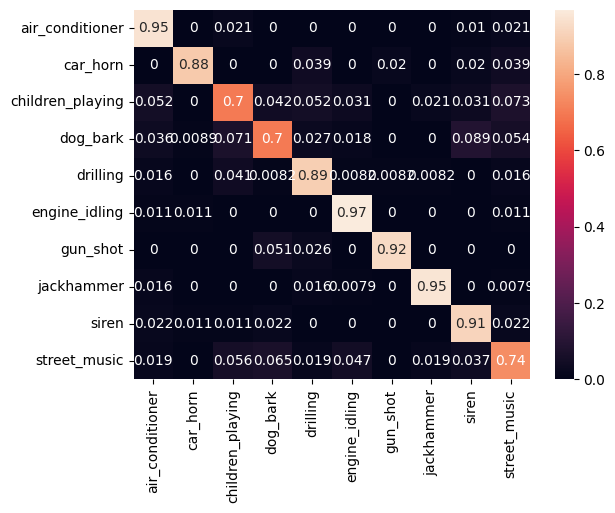

In [179]:
plot_confusion_matrix(
    rnn_mel,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram,n_mels = 64
)

## Задание 5. Cверточная сеть для классификации аудиозаписей по мелспектрограммам. (2 балла)

Легко заметить, что мелспектрограммы имеют четко выраженные паттерны - если приноровиться, то даже человек, посмотрев на мелспектрограмму, сможет _визуально_ проклассифицировать объект.

Это позволяет свести задачу классификации аудиозаписей к задаче классификации картинок.

Реализуем такую сверточную сеть:

* 2x (Conv2d 3x3 @ 16, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 32, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 64, BatchNorm2d, ReLU)
* MaxPoll 2x2
* (Conv2d 3x3 @ 128, BatchNorm2d, ReLU)
* (Conv2d 2x2 @ 128, BatchNorm2d, ReLU)
* Global MaxPoll
* Fully Connected 128, ReLU
* Fully Connected 10

Совет: подобная архитектура была реализована в [**PANNs: Large-Scale Pretrained Audio Neural Networks for Audio Pattern Recognition**](https://arxiv.org/pdf/1912.10211.pdf), можете использовать эту статью как референс.


**За реализацию архитектуры дается 1.5 балла.**

In [117]:
class CNN10(nn.Module):
    def __init__(self, num_classes=10, hidden=16):
        super().__init__()

        ### YOUR CODE IS HERE ######
        maxpool = nn.MaxPool2d(2)
        conv_1 = nn.Sequential(nn.Conv2d(1,16,3),nn.BatchNorm2d(16),nn.ReLU(),
                              nn.Conv2d(16,16,3),nn.BatchNorm2d(16),nn.ReLU())
        conv_2 = nn.Sequential(nn.Conv2d(16,32,3),nn.BatchNorm2d(32),nn.ReLU(),
                              nn.Conv2d(32,32,3),nn.BatchNorm2d(32),nn.ReLU())
        conv_3 = nn.Sequential(nn.Conv2d(32,64,3),nn.BatchNorm2d(64),nn.ReLU(),
                              nn.Conv2d(64,64,3),nn.BatchNorm2d(64),nn.ReLU())
        conv_4 = nn.Sequential(nn.Conv2d(64,128,3),nn.BatchNorm2d(128),nn.ReLU(),
                               nn.Conv2d(128,128,2),nn.BatchNorm2d(128),nn.ReLU())
        self.cnn_backbone = nn.Sequential(conv_1,maxpool,conv_2,maxpool,conv_3,maxpool,conv_4)

        self.final_mlp = nn.Sequential(nn.Linear(128,128),nn.ReLU(),nn.Linear(128,10))
        ### THE END OF YOUR CODE ###

    def forward(self, x, lens):
        z = self.cnn_backbone(x[:, None, :, :])
        z = torch.nn.functional.max_pool2d(z, kernel_size=z.size()[2:])[:, :, 0, 0]
        return self.final_mlp(z)

In [123]:
cnn = CNN10()
cnn.to(device)



CNN10(
  (cnn_backbone): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3,

Epoch 9


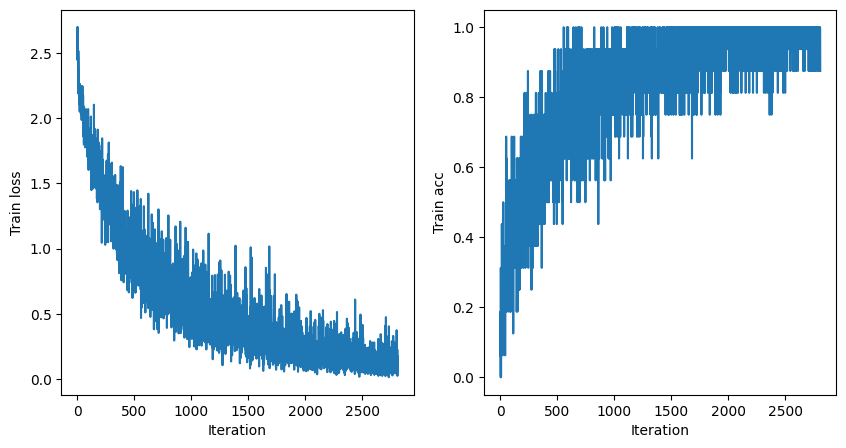

In [124]:
optim = torch.optim.Adam(cnn.parameters(), lr=1e-4)
train_audio_clfr(
    cnn,
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram,
    num_epochs=10,
)

**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.85 на валидационном датасете.**

Val accuracy: 0.9187165775401069


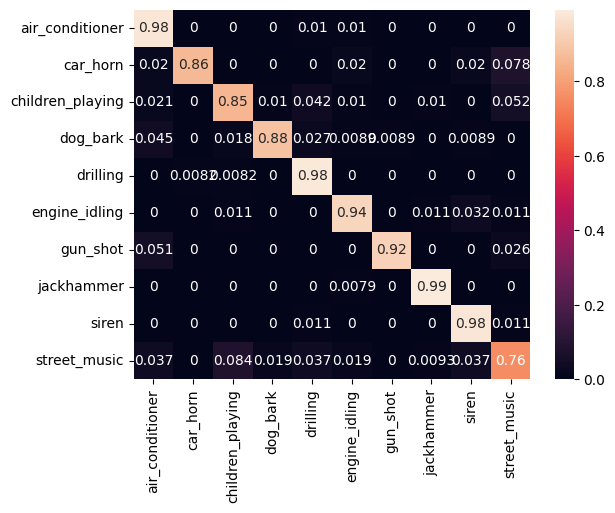

In [126]:
plot_confusion_matrix(
    cnn,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram,
)

## Задание 6. Аугментация SpecAugment (2 балла)

Обычно датасеты с аудиозаписями довольно малы. Наш датасет тому пример - всего 4500 объектов в обучающей выборке. Обучение глубокий сетей с большим кол-вом параметров на таких датасетах часто ведет к переобучению и проседанию метрик на валидационном и тестовом датасетах.

Для борьбы с переобучением имеет смысл использовать аугментацию данных. Для мелспектрограмм была придумана аугментация под названием SpecAugment.

Смысл её очень прост - зануление спектрограммы по временным промежуткам и по мел-частотам:
1. Выбираются несколько временных промежутков ${[t^1_i, t^2_i]}$ и заполняют спектрограмму $s[t^1_i : t^2_i, :]$ значением $v$.

2. Выбираются несколько промежутков мелчастот ${[m^1_i, m^2_i]}$ и заполняют спектрограмму $s[:, m^1_i : m^2_i]$ значением $v$.

В качестве значения $v$ выбирают:
1. `'mean'`: среднее по спектрограмме
2. `'min'`: минимум по спектрограмме
3. `'max'`: максимум по спектрограмме
5. `v`: некоторая константа

Совет: описание аугментации можно найти здесь: [link](https://neurohive.io/ru/novosti/specaugment-novyj-metod-augmentacii-audiodannyh-ot-google-ai/), можете использовать эту ссылку как референс.

![specaugment](https://neurohive.io/wp-content/uploads/2019/04/image6.png)

В этом задании Вам предлагается реализовать аугментацию SpecAugment.

**За реализацию аугментации дается 1.5 балла.**


In [127]:
a =torch.rand((10,5,4)) 
b = torch.mean(a,(1,2))
b

tensor([0.5332, 0.4852, 0.5454, 0.5575, 0.4189, 0.5074, 0.4562, 0.5023, 0.5934,
        0.5653])

In [128]:
b.expand(5,6,-1)[...,0].shape

torch.Size([5, 6])

In [129]:
c = torch.rand((10,6))
c[:,1:] = b.expand(5,-1).transpose(0,1)
c

tensor([[0.4918, 0.5332, 0.5332, 0.5332, 0.5332, 0.5332],
        [0.1354, 0.4852, 0.4852, 0.4852, 0.4852, 0.4852],
        [0.0967, 0.5454, 0.5454, 0.5454, 0.5454, 0.5454],
        [0.9802, 0.5575, 0.5575, 0.5575, 0.5575, 0.5575],
        [0.5938, 0.4189, 0.4189, 0.4189, 0.4189, 0.4189],
        [0.9453, 0.5074, 0.5074, 0.5074, 0.5074, 0.5074],
        [0.3646, 0.4562, 0.4562, 0.4562, 0.4562, 0.4562],
        [0.7729, 0.5023, 0.5023, 0.5023, 0.5023, 0.5023],
        [0.6364, 0.5934, 0.5934, 0.5934, 0.5934, 0.5934],
        [0.1308, 0.5653, 0.5653, 0.5653, 0.5653, 0.5653]])

In [130]:
import random


class SpectAugment:
    def __init__(
        self,
        filling_value="mean",
        n_freq_masks=2,
        n_time_masks=2,
        max_freq=10,
        max_time=50,
    ):

        self.filling_value = filling_value
        self.n_freq_masks = np.random.randint(n_freq_masks)
        self.n_time_masks = np.random.randint(n_time_masks)
        self.max_freq = max_freq
        self.max_time = max_time

    def __call__(self, spect, lens):
        m = torch.mean(spect,(1,2))
        for i in range(self.n_time_masks):
            end_t = spect.shape[2]//self.n_time_masks
            t_start = i*end_t+np.random.randint(end_t)
            gap = np.random.randint(self.max_time)
            if t_start+gap>spect.shape[2]:
                gap =spect.shape[2]-t_start
#             print(t_start,gap)
            vec = m.expand(gap,spect.shape[1],-1).transpose(0,2)
            spect[...,t_start:t_start+gap] = vec
        for i in range(self.n_freq_masks):
            end_f = spect.shape[1]//self.n_freq_masks
            f_start = i*end_f+np.random.randint(end_f)
            gap = np.random.randint(self.max_freq)
            if f_start+gap>spect.shape[1]:
                gap =spect.shape[1]-f_start
#             print(f_start,gap)
            vec = m.expand(spect.shape[2],gap,-1).transpose(0,2)
            spect[:,f_start:f_start+gap,:] = vec
        return spect,lens

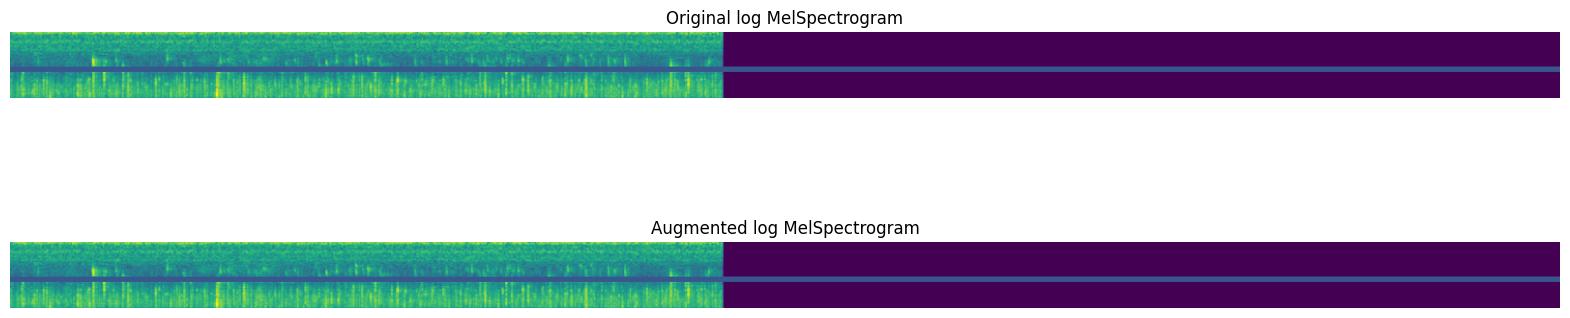

In [131]:
# применим аугментацию к данным
for batch in train_dataloader:
    break

x = batch["x"].to(device)
lens = batch["len"].to(device)
x_logmel, lens = compute_log_melspectrogram_reference(
    x, lens, sr=train_dataset.sr, device=device
)
x_logmel_augmented, lens = SpectAugment()(x_logmel, lens)

# нарисуем спектрограмму до и после аугментации
plt.figure(figsize=(20, 5))
plt.subplot(2, 1, 1)
plt.title("Original log MelSpectrogram")
plt.axis("off")
plt.imshow(x_logmel[0].cpu().numpy())

plt.subplot(2, 1, 2)
plt.title("Augmented log MelSpectrogram")
plt.axis("off")
plt.imshow(x_logmel_augmented[0].cpu().numpy())

plt.show()

In [132]:
cnn = CNN10()
cnn.to(device)



CNN10(
  (cnn_backbone): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3,

Epoch 9


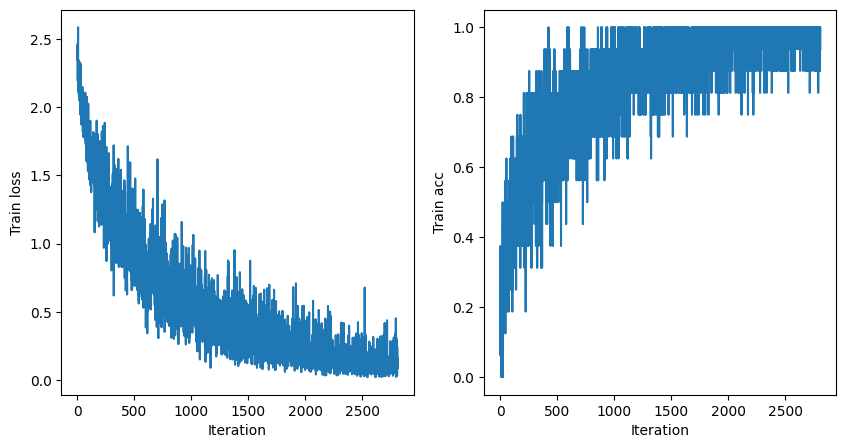

In [133]:
# обучим модель на данных с аугментациями
optim = torch.optim.Adam(cnn.parameters(), lr=1e-4)
train_audio_clfr(
    cnn,
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram,
    augmentation=SpectAugment(n_freq_masks=2,
        n_time_masks=5,
        max_freq=10,
        max_time=20,),
    num_epochs=10,
)

Epoch 2


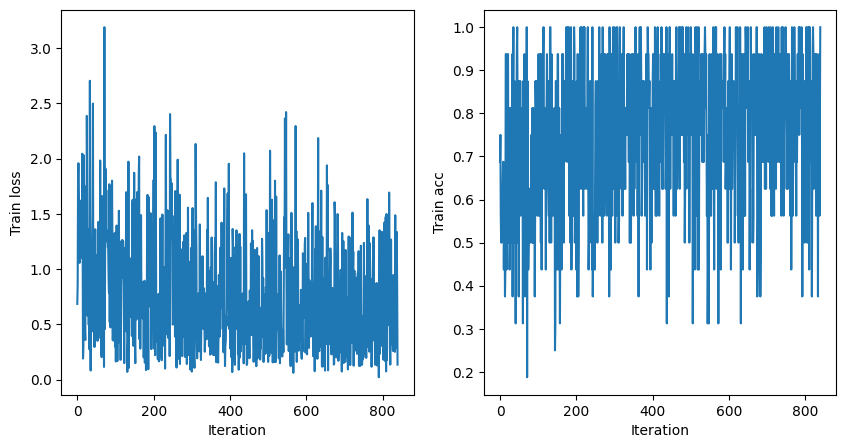

In [135]:
optim = torch.optim.Adam(cnn.parameters(), lr=1e-6)
train_audio_clfr(
    cnn,
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram,
    augmentation=SpectAugment(n_freq_masks=2,
        n_time_masks=5,
        max_freq=10,
        max_time=20,),
    num_epochs=3,
)

**Задание: для получения 0.5 балла сделайте подбор параметров аугментации и добейтесь accuracy модели выше 0.9 на валидационном датасете.**

Val accuracy: 0.9197860962566845


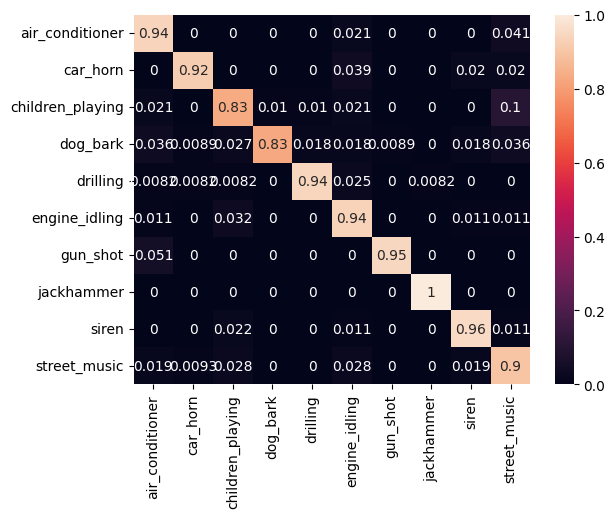

In [138]:
plot_confusion_matrix(
    cnn,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram,
)